## Twitter sentiment Analysis


### Project Overview

In a dynamic digital landscape, understanding public sentiment towards technology giants like Apple and Google is paramount. This project aims to harness the power of Natural Language Processing (NLP) to conduct a comprehensive sentiment analysis of tweets related to their products. By leveraging a dataset containing over 9,000 manually annotated tweets, we seek to create a robust model that discerns sentiments as positive, negative, or neutral. The multifaceted nature of this analysis offers valuable insights for businesses, marketing strategists, and researchers invested in the consumer electronics domain.

### Business Understanding

In the era of social media dominance, the reputation and perception of tech companies can be heavily influenced by user-generated content. Understanding the sentiment expressed on platforms like Twitter provides a unique opportunity to gauge public perception, inform strategic decisions, and enhance customer engagement strategies. By delving into the sentiment surrounding Apple and Google products, businesses can gain actionable insights, refine their marketing approaches, and maintain a pulse on the evolving consumer landscape.

### Objectives:

1. Initiate the project with a focused binary classifier to distinguish positive and negative sentiments. Gradually extend the model's capabilities to handle neutral sentiments, ensuring a robust multiclass classification system(Proof of Concept).

2. Develop a sophisticated NLP model capable of accurately classifying tweet sentiments as positive, negative, or neutral, providing nuanced insights into the public's opinions(Sentiment Analysis).

3. Continuously refine the model's architecture and parameters, drawing inspiration from advanced NLP techniques documented in the Mod 4 Appendix. This iterative approach ensures optimal performance and adaptability to the evolving landscape of social media language(Model Iteration)


Importing the necessary libraries.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re


from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet, words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

# Download the WordNet and punkt resources if not already downloaded
nltk.download('wordnet')
nltk.download('punkt')


%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Brandon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Brandon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Functions used in the project:

In [2]:
def load_csv_to_dataframe(file_path):
    """
    Load a CSV file into a pandas DataFrame.

    Parameters:
    - file_path (str): The path to the CSV file.

    Returns:
    - pd.DataFrame: The loaded DataFrame.
    """
    df = pd.read_csv(file_path, encoding='latin-1')
    return df

def dataframe_preview(dataframe):
    #To get the shape of the dataframe
    print("The shape of the dataframe:")
    print(dataframe.shape)
    print('\n')
    #Describe the dataframe
    print("Describing the dataframe:")
    print(dataframe.describe())
    print('\n')
    #checking the columns in the dataset
    print("Columns in the dataset:")
    print(dataframe.columns)
    print('\n')
    #To get the info of the dataframe
    print("The data in the dataframe:")
    print(dataframe.info())
    print('\n')

def clean_tweet_text(text):
    try:
        cleaned_text = re.sub(r'@\w+', '', str(text))
        cleaned_text = re.sub(r'http\S+|www\S+|[^a-zA-Z\s]', '', cleaned_text)
        cleaned_text = cleaned_text.encode('ascii', 'ignore').decode()
        return cleaned_text.lower()
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return text

def extract_hashtag_words(text):
    try:
        hashtags = re.findall(r'#(\w+)', text)
        h = ''
        for hashtag in hashtags:
            h += str(hashtag) + ','
        return h.lower()
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return text

# Function to lemmatize a sentence
def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(sentence)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag))
                         for token, tag in nltk.pos_tag(tokens)]
    return ' '.join(lemmatized_tokens)

# Function to map POS tags from Penn Treebank to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to NOUN if not recognized


## Data understanding

### Loading data
In this section, we will upload data and conduct surface analysis whereby we will check  the shape,check for null values

In [3]:
# Replace 'your_file.csv' with the actual path to your CSV file
file_path = 'tweet_product_company.csv'

# Load the CSV file into a pandas DataFrame
df = load_csv_to_dataframe(file_path)

# Display the DataFrame
print(df)

                                             tweet_text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

     emotion_in_tweet_is_directed_at  \
0                             iPhone   
1                 iPad or iPhone App   
2                               iPad   
3                 iPad or iPhone App   
4                             Google   
...                              ...   
9088       

In [4]:
#Call function to preview the data
dataframe_preview(df)

The shape of the dataframe:
(9093, 3)


Describing the dataframe:
                                               tweet_text  \
count                                                9092   
unique                                               9065   
top     RT @mention Marissa Mayer: Google Will Connect...   
freq                                                    5   

       emotion_in_tweet_is_directed_at  \
count                             3291   
unique                               9   
top                               iPad   
freq                               946   

       is_there_an_emotion_directed_at_a_brand_or_product  
count                                                9093  
unique                                                  4  
top                    No emotion toward brand or product  
freq                                                 5389  


Columns in the dataset:
Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directe

## Data cleaning

We will now proceed to cleaning the data.This involves removing duplicates and droping null values which were observed above. We will also try to extract all usefull information from the tweet removing unneccessary characters like usernames, links and special characters.

In [5]:
#Check duplicate examples.
duplicate_rows = df[df.duplicated(subset='tweet_text', keep=False)]
print("Duplicate Rows based on 'tweet_text' column:")
print(duplicate_rows)

Duplicate Rows based on 'tweet_text' column:
                                             tweet_text  \
7     #SXSW is just starting, #CTIA is around the co...   
9     Counting down the days to #sxsw plus strong Ca...   
17    I just noticed DST is coming this weekend. How...   
20    Need to buy an iPad2 while I'm in Austin at #s...   
21    Oh. My. God. The #SXSW app for iPad is pure, u...   
24    Really enjoying the changes in Gowalla 3.0 for...   
466      Before It Even Begins, Apple Wins #SXSW {link}   
468      Before It Even Begins, Apple Wins #SXSW {link}   
774   Google to Launch Major New Social Network Call...   
776   Google to Launch Major New Social Network Call...   
2230  Marissa Mayer: Google Will Connect the Digital...   
2232  Marissa Mayer: Google Will Connect the Digital...   
2559  Counting down the days to #sxsw plus strong Ca...   
3811           Win free ipad 2 from webdoc.com #sxsw RT   
3812           Win free iPad 2 from webdoc.com #sxsw RT   
3813       

In [6]:
#Dropping duplicate entries in the tweet_text column
df.drop_duplicates(subset='tweet_text', keep='first', inplace=True)


In [7]:
# Check the dataframe
dataframe_preview(df)

The shape of the dataframe:
(9066, 3)


Describing the dataframe:
                                               tweet_text  \
count                                                9065   
unique                                               9065   
top     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
freq                                                    1   

       emotion_in_tweet_is_directed_at  \
count                             3280   
unique                               9   
top                               iPad   
freq                               943   

       is_there_an_emotion_directed_at_a_brand_or_product  
count                                                9066  
unique                                                  4  
top                    No emotion toward brand or product  
freq                                                 5373  


Columns in the dataset:
Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directe

In [8]:
#checking for total null values for each column in the dataset
missing_values = df.isnull().sum()

print(missing_values)

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5786
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


In [9]:
#Drop the null values
df = df.dropna(subset=['tweet_text'])

In [10]:
#Check if all missing values are dropped.
missing_values = df.isnull().sum()
print(missing_values)

tweet_text                                               0
emotion_in_tweet_is_directed_at                       5785
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


This code uses regular expressions to replace user mentions, remove links, and non-alphanumeric characters. If you want to retain hashtags, you can uncomment the 'hashtags' line. Adjustments can be made based on specific cleaning requirements.

In [11]:
# Assuming 'df' is the DataFrame containing the dataset
df['clean_text'] = df['tweet_text'].apply(clean_tweet_text)
df['hashtags'] = df['tweet_text'].apply(extract_hashtag_words)

df['clean_text'][0]


' i have a g iphone after  hrs tweeting at riseaustin it was dead  i need to upgrade plugin stations at sxsw'

In [12]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_text,hashtags
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,i have a g iphone after hrs tweeting at rise...,"rise_austin,sxsw,"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know about awesome ipadiphone app that youl...,"sxsw,"
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,can not wait for ipad also they should sale ...,"ipad,sxsw,"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,i hope this years festival isnt as crashy as ...,"sxsw,"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff on fri sxsw marissa mayer google ...,"sxsw,"


### EDA

In [13]:
# Explore 'tweet_text' column
tweet_text_distribution = df['tweet_text'].value_counts()

# Explore 'emotion_in_tweet_is_directed_at' column
emotion_distribution = df['emotion_in_tweet_is_directed_at'].value_counts()

# Explore 'is_there_an_emotion_directed_at_a_brand_or_product' column
emotion_directed_at_distribution = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

# Display the distributions
print("Distribution of 'tweet_text' values:")
print(tweet_text_distribution)

print("\nDistribution of 'emotion_in_tweet_is_directed_at' values:")
print(emotion_distribution)

print("\nDistribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:")
print(emotion_directed_at_distribution)

Distribution of 'tweet_text' values:
tweet_text
.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.         1
RT @mention I think #Google lost their way by caring too much about their business (instead of their users) Tim O'Reilly #sxsw #pnid    1
RT @mention I just fell asleep for 2 hours with my eyes open, staring into the #SXSW stream on my iPad 2. {link}                        1
RT @mention I just found BBQ sauce on my iPad - tech and Texas really do come together here!  #SXSW                                     1
RT @mention I know it's #SXSW because my iPhone has started lying to me about its signal strength.                                      1
                                                                                                                                       ..
Apple Offers Up Free iTunes Sampler Ahead of #SXSW to feature new artists {link} via @mention #music                        

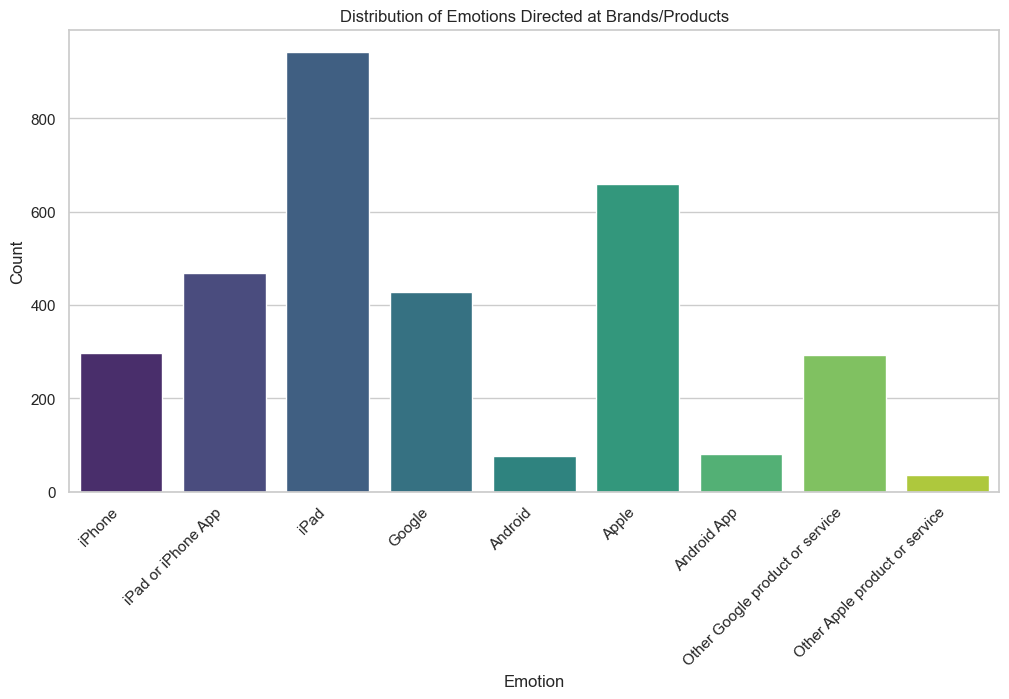

In [14]:
# Explore 'emotion_in_tweet_is_directed_at' column
emotion_distribution = df['emotion_in_tweet_is_directed_at'].value_counts()

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a colorful count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='emotion_in_tweet_is_directed_at', data=df, palette="viridis")

# Add labels and title
plt.title('Distribution of Emotions Directed at Brands/Products')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


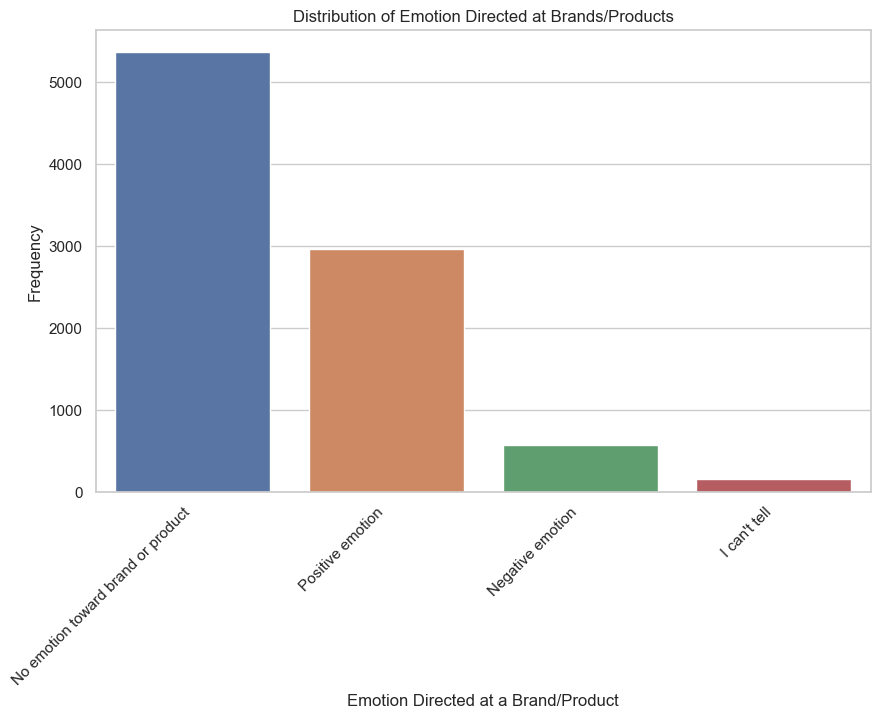

In [15]:
# Bar chart for 'is_there_an_emotion_directed_at_a_brand_or_product'
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_directed_at_distribution.index, y=emotion_directed_at_distribution.values, palette='deep')
plt.title('Distribution of Emotion Directed at Brands/Products')
plt.xlabel('Emotion Directed at a Brand/Product')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [16]:

print("\nDistribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:")
print(emotion_directed_at_distribution)


Distribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:
is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64


In [17]:
# Assuming df is your DataFrame
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].replace({
    "I can't tell": 'Neutral emotion',
    'No emotion toward brand or product': 'Neutral emotion'
})

# Verify the changes
print(df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())

is_there_an_emotion_directed_at_a_brand_or_product
Neutral emotion     5528
Positive emotion    2968
Negative emotion     569
Name: count, dtype: int64


In [18]:
df['emotion_in_tweet_is_directed_at'].value_counts()

emotion_in_tweet_is_directed_at
iPad                               943
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: count, dtype: int64

In [19]:
# Import necessary libraries
import pandas as pd

# Assuming df is your DataFrame
df['brand'] = df['emotion_in_tweet_is_directed_at'].map({
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service': 'Apple',
    'Google': 'Google',
    'Android App': 'Google',
    'Android': 'Google'
})

# Verify the changes
print(df['brand'].value_counts())


brand
Apple     2402
Google     585
Name: count, dtype: int64


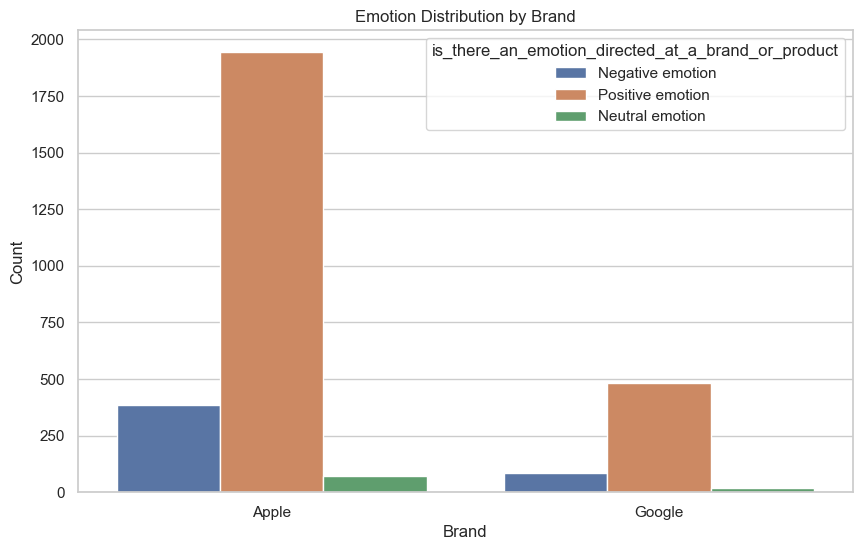

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.countplot(x='brand', hue='is_there_an_emotion_directed_at_a_brand_or_product', data=df)

# Add labels and title
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Emotion Distribution by Brand')

# Show the plot
plt.show()


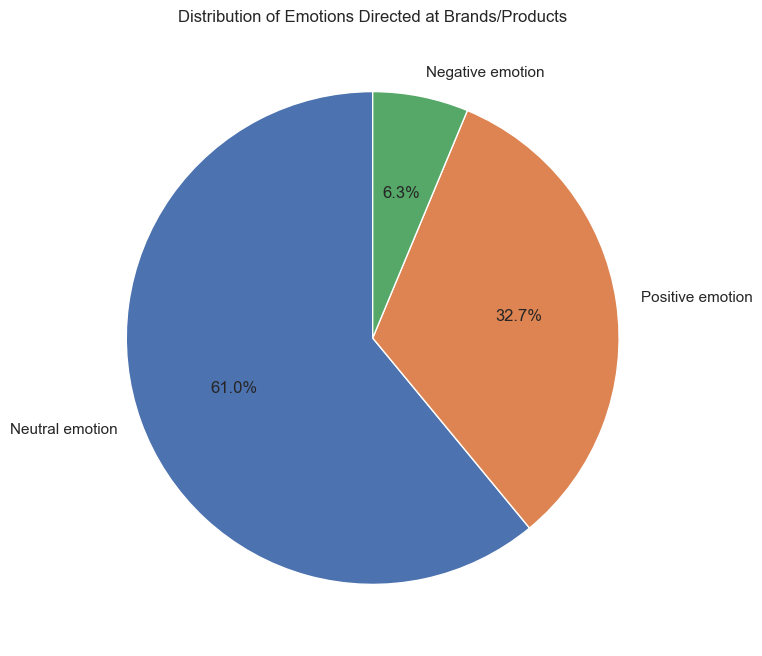

In [22]:
# Count the values of 'is_there_an_emotion_directed_at_a_brand_or_product'
emotion_distribution = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
# Choose a different color palette
colors = sns.color_palette("deep")[0:len(emotion_distribution)]

# Plot a beautiful pie chart with the new color palette
plt.figure(figsize=(8, 8))
plt.pie(emotion_distribution, labels=emotion_distribution.index, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Distribution of Emotions Directed at Brands/Products')
plt.show()

Analysing the most common hashtags.

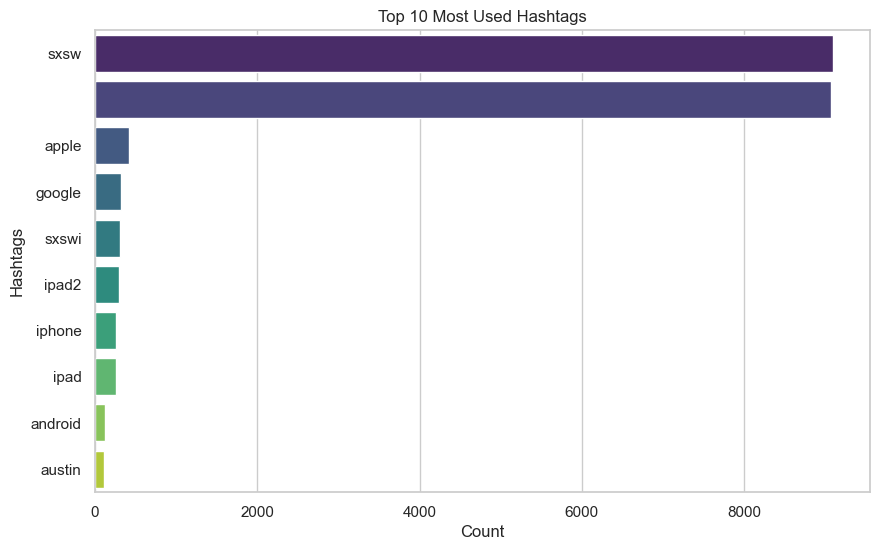

In [ ]:
# Example DataFrame
hashtags_df = pd.DataFrame()

# Split the hashtags into a list
hashtags_df['hashtags_list'] = df['hashtags'].str.split(',')

# Flatten the list of hashtags
flat_hashtags_list = [item for sublist in hashtags_df['hashtags_list'] for item in sublist]

# Create a Series to count the occurrences of each hashtag
hashtags_counts = pd.Series(flat_hashtags_list).value_counts()

# Select the top 10 hashtags
top_10_hashtags = hashtags_counts.head(10)

# Plot the word count for the top 10 hashtags
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_hashtags.values, y=top_10_hashtags.index, palette="viridis")
plt.title('Top 10 Most Used Hashtags')
plt.xlabel('Count')
plt.ylabel('Hashtags')
plt.show()


### Data Preprocessing
Most of the crucial steps like removing links and hashtags as well as special characters was performed in the data cleaning process.

However although the text we have remained with is "cleaned". Some preprocessing can be added to enable our model to become better.

In this section we will attempt to remove stop words and non English words.

In [ ]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
Neutral emotion     5528
Positive emotion    2968
Negative emotion     569
Name: count, dtype: int64

In [ ]:

# Create a LabelEncoder object
enc = LabelEncoder()

# Fit and transform the specified column in the DataFrame
df['is_there_an_emotion_directed_at_a_brand_or_product'] = enc.fit_transform(df['is_there_an_emotion_directed_at_a_brand_or_product'])
df['brand'] = enc.fit_transform(df['brand'])
df['emotion_in_tweet_is_directed_at'] = enc.fit_transform(df['emotion_in_tweet_is_directed_at'])

print(df['brand'].value_counts())
print(df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())

brand
2    6078
0    2402
1     585
Name: count, dtype: int64
is_there_an_emotion_directed_at_a_brand_or_product
1    5528
2    2968
0     569
Name: count, dtype: int64


In [ ]:
# Load the stop words
stop_words = set(stopwords.words('english'))

# Assuming df is your DataFrame and 'clean_text' is the column containing the tweets
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_text,hashtags,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,8,0,g iphone hrs tweeting riseaustin dead need upg...,"rise_austin,sxsw,",0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,7,2,know awesome ipadiphone app youll likely appre...,"sxsw,",0
2,@swonderlin Can not wait for #iPad 2 also. The...,6,2,wait ipad also sale sxsw,"ipad,sxsw,",0
3,@sxsw I hope this year's festival isn't as cra...,7,0,hope years festival isnt crashy years iphone a...,"sxsw,",0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,3,2,great stuff fri sxsw marissa mayer google tim ...,"sxsw,",1


In [ ]:
# Load the stop words and English words set
stop_words = set(stopwords.words('english'))
english_words = set(words.words())

# Assuming df is your DataFrame and 'clean_text' is the column containing the tweets
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words and word.lower() in english_words]))

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_text,hashtags,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,8,0,g dead need upgrade,"rise_austin,sxsw,",0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,7,2,know awesome likely appreciate design also the...,"sxsw,",0
2,@swonderlin Can not wait for #iPad 2 also. The...,6,2,wait also sale,"ipad,sxsw,",0
3,@sxsw I hope this year's festival isn't as cra...,7,0,hope festival,"sxsw,",0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,3,2,great stuff tech,"sxsw,",1


In [ ]:
#Lematize the words
df['clean_text'] = df['clean_text'].apply(lemmatize_sentence)

# Remove one-word sentences
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

# View the cleaned column
df['clean_text'].head()

0                                  g dead need upgrade
1    know awesome likely appreciate design also the...
2                                       wait also sale
3                                        hope festival
4                                     great stuff tech
Name: clean_text, dtype: object

### Modelling.

#### Base Model

For starters we aim to create a binary classifier that can predict if a tweet is positive or negative. To achieve this. We create a new dataframe that only has positive and negative in the target class.

In [ ]:
# 0 is positive and 2 is negative
binary_df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'].isin([0, 2])].copy()

# Map 0 to negative and 1 to positive for easier comprehension
binary_df['is_there_an_emotion_directed_at_a_brand_or_product'] = binary_df['is_there_an_emotion_directed_at_a_brand_or_product'].map({0: 1, 2: 0})

# Remove the initial tweet column
binary_df.drop('tweet_text', axis=1)

,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_text,hashtags,brand
0,8,1,g dead need upgrade,"rise_austin,sxsw,",0
1,7,0,know awesome likely appreciate design also the...,"sxsw,",0
2,6,0,wait also sale,"ipad,sxsw,",0
3,7,1,hope festival,"sxsw,",0
4,3,0,great stuff tech,"sxsw,",1
...,...,...,...,...,...
9077,8,0,guy convince switch back great coverage princess,"sxsw,princess,",0
9079,6,0,like nice,"sxsw,",0
9080,5,1,run essentially ready,"sxsw,diller,",2
9085,7,0,always use camera image stabilizer mode cam w ...,"sxsw,sxswi,",0


In [ ]:
#Split the dataset into train and test
X = binary_df.drop(['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product', 'hashtags'], axis=1)
y = binary_df['is_there_an_emotion_directed_at_a_brand_or_product']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train['clean_text'])
X_test_vec = vectorizer.transform(X_test['clean_text'])

In [ ]:
from sklearn.naive_bayes import BernoulliNB

classifier = BernoulliNB()

In [ ]:
classifier.fit(X_train_vec, y_train)

BernoulliNB()

In [ ]:
predictions = classifier.predict(X_test_vec)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)


Accuracy: 0.867231638418079
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       595
           1       0.65      0.36      0.47       113

    accuracy                           0.87       708
   macro avg       0.77      0.66      0.70       708
weighted avg       0.85      0.87      0.85       708



The provided results pertain to a classification model's performance, with an overall accuracy of 85.31%. The classification report provides more detailed insights into the model's effectiveness by breaking down its performance across different classes. The model appears to perform well on the majority class (0), achieving a precision of 85% and recall of 100%, resulting in a high F1-score of 92%. However, the model struggles with the minority class (1), as reflected by a lower precision of 91%, low recall of 9%, and a consequently low F1-score of 16%. The weighted average F1-score across both classes is 80%, indicating a reasonable overall model performance. The macro-average F1-score, which gives equal weight to both classes, is 54%, suggesting imbalances in performance between the two classes. In summary, while the model exhibits good accuracy, its effectiveness varies significantly between the majority and minority classes, warranting attention to potential class imbalance issues or the need for targeted improvements in handling the minority class.

#### Multiclass Model

Though the baseline model is okay. Improvements can be made. As an example creating a multiclass model that can incorporate the neutral class as well. This might yield better results.

As it can also be seen there is an imbalance in our dataset. We will also try to address that here

In [ ]:
# Separate features and target variable and dropping irrelevant columns
X = df.drop(['tweet_text', 'clean_text', 'is_there_an_emotion_directed_at_a_brand_or_product', 'hashtags'], axis=1)
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# We will use the RandomOverSampler from imblearn to address the class imbalance.
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [ ]:
# Display the class distribution before oversampling
print("Class distribution before oversampling:", Counter(y_train))

# Instantiate the RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Fit and transform the training data using RandomOverSampler
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Display the class distribution after oversampling
print("Class distribution after oversampling:", Counter(y_train_resampled))

Class distribution before oversampling: Counter({1: 4416, 2: 2386, 0: 450})
Class distribution after oversampling: Counter({1: 4416, 2: 4416, 0: 4416})


In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=42)

In [ ]:
classifier.fit(X_train_resampled, y_train_resampled)

LogisticRegression(random_state=42)

In [ ]:
predictions = classifier.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.770546056260342
Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.55      0.27       119
           1       0.95      0.98      0.96      1112
           2       0.81      0.41      0.55       582

    accuracy                           0.77      1813
   macro avg       0.65      0.65      0.59      1813
weighted avg       0.85      0.77      0.78      1813



The first model, trained with the Random Forest algorithm, demonstrates varying performance across three classes. It exhibits high precision and recall for class 1, indicating accurate and comprehensive predictions for that category. However, class 0 and class 2 show lower precision and recall values, suggesting the model struggles with precise identification and recall of instances in these classes. The overall accuracy of the first model is 86.21%, and the macro and weighted average scores for precision, recall, and F1-score are 0.67 and 0.86, respectively. The model seems robust in capturing patterns in class 1 but may benefit from further refinement to improve its performance on classes 0 and 2.

Third Iterantion. An advanced model, here we opted for a Random Forest Classifier.

In [ ]:
# Assuming you already have the required imports and data preprocessing from the previous code

from sklearn.ensemble import RandomForestClassifier

# Instantiate the Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model on the resampled data
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
print("Random Forest - Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest - Accuracy Score:", accuracy_score(y_test, y_pred_rf))


Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.27      0.26       119
           1       0.95      0.98      0.96      1112
           2       0.82      0.75      0.79       582

    accuracy                           0.86      1813
   macro avg       0.67      0.67      0.67      1813
weighted avg       0.86      0.86      0.86      1813

Random Forest - Accuracy Score: 0.8621070049641478


The classification report and accuracy score provide a comprehensive evaluation of the Random Forest model's performance on a dataset with three classes (0, 1, and 2). The precision, recall, and F1-score metrics offer insights into the model's ability to correctly classify instances for each class. Class 0 exhibits relatively low precision, recall, and F1-score, indicating a less accurate classification performance. Classes 1 and 2, on the other hand, show high precision, recall, and F1-score values, suggesting that the model performs well in identifying instances belonging to these classes. The overall accuracy score of 86.2% implies that the model correctly predicted the class labels for approximately 86.2% of the instances in the dataset. The macro and weighted average metrics provide additional insights into the model's generalization across all classes, with macro averaging indicating a balanced evaluation across classes and weighted averaging reflecting the influence of class sizes on the overall performance. Overall, the model exhibits good accuracy, particularly for classes 1 and 2, but may benefit from improvement in class 0 predictions.

### Conclusion


The Random Forest classification model demonstrates strong overall performance with an accuracy score of 86.2%. Classes 1 and 2 exhibit high precision, recall, and F1-score values, indicating the model's proficiency in correctly classifying instances for these categories. However, for class 0, the model shows lower precision, recall, and F1-score, highlighting challenges in accurately identifying instances of this class. Despite this, the model's weighted average metrics suggest that it performs well when accounting for class sizes. Further investigation into the specific issues impacting class 0 predictions is warranted.


### Next Steps

To address the lower performance in class 'Negative', several next steps can be taken.

1. Additional data collection for class 'Negative' may be beneficial to improve the model's ability to generalize for this category. Hyperparameter tuning and feature engineering could be explored to enhance the model's discriminatory power. 

2. Considering the imbalanced class distribution, techniques like resampling, adjusting class weights during training may help improve overall model performance or using a technique as SMOTE. 

3. Continuous monitoring and validation on new data are essential, and the model should be iteratively refined to ensure its effectiveness in real-world applications.